## Simulation-Based Inference SIR Model: Training and Coverage Data
> Created: Mar 23 2024 Harrison B. Prosper and Ali Al Kadhim<br>


In [1]:
import os, sys
import numpy as np
import pandas as pd

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

from tqdm import tqdm
from genutil import generate, observe, Fsolve, SIRdata

### Load sample of scaled $(\alpha, \beta)$ parameter points

In [3]:
NPARAMS  = 1000
paramsdf = pd.read_csv('../../data/SIR_alpha_beta.csv.gz', nrows=NPARAMS)
print(f'number of parameter points: {len(paramsdf):d}')
paramsdf[:5]

number of parameter points: 1000


,alpha,beta
0,0.556824,0.432547
1,0.917183,0.617733
2,0.222595,0.684092
3,0.513685,0.231400
4,0.533168,0.343659


### Generate synthetic epidemics
For each of parameter point $\theta = (\alpha, \beta)$ simulate $K = 500$ epidemics. To avoid spikes in the distributions of test statistics, filter out simulations in which the epidemic dies out within a day.

In [16]:
def test_statistic(i, I):
    a = [(d-f)**2/f for d, f in zip(i, I)]
    return np.sqrt(np.array(a).mean()) / SIRdata.scale

def plot_test_statistics(li, lo=None,
                         xbins=50, xmin=0, xmax=0.25,
                         filename='../../images/fig_SIR_test_statistics.png', 
                         fgsize=(6, 4), ftsize=16):

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    fig.tight_layout()
    
    # adjust padding
    #plt.subplots_adjust(hspace=0.25)
    #plt.subplots_adjust(wspace=0.40)

    # work out number of rows
    ncols = 1
    nrows = 1
    ax = fig.add_subplot(nrows, ncols, 1)

    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$\lambda$', fontsize=ftsize)

    ax.set_ylabel(r'$f(\lambda|\theta_0)$', fontsize=ftsize)

    ax.hist(li, bins=xbins, range=(xmin, xmax), 
            color='steelblue', density=True, alpha=0.4)
    
    if type(lo) != type(None):
        ax.hist(lo, bins=xbins, range=(xmin, xmax), 
            color='darkorange', density=True, alpha=0.4)
    print(filename)
    plt.savefig(filename)

### Test generation
With `apply_filter = False` spikes will be visible in the distribution of the test statistic due to the epidemics that die off quickly.

[3.0, 25.413, 66.242, 140.764, 212.17, 226.209, 190.004, 139.963, 96.891, 64.748, 42.311, 27.325, 17.533]


100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 88.97it/s]


../../images/fig_SIR_test_statistics.png


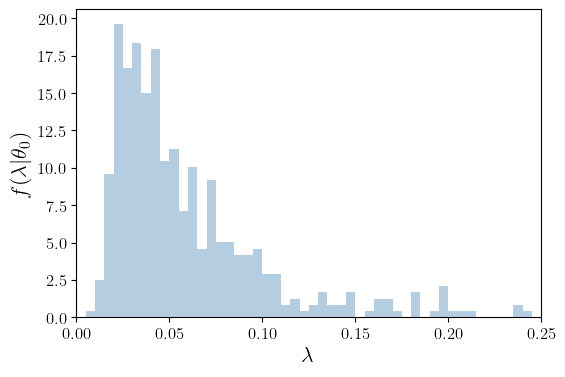

In [19]:
alpha = paramsdf.alpha
beta  = paramsdf.beta
J = 0
a = alpha[J]
b = beta[J]
K = 500

apply_filter = True

# solve ODEs for current parameter point
soln = Fsolve(a, b, SIRdata)
I    = soln.y[1]

# reduce number of significant figures
I = [float(int(1000*x))/1000 for x in I]
print(I)

# simulate K epidemics and compute the
# associated test statistics
params = (a, b)
l = []
counts = []
for k in tqdm(range(K)):

    # generate data for one epidemic (defined as a sequence of 4-tuples: [t, s, i, r])
    # t: time of event
    # s: number of suceptible individuals at time t
    # i: number of affected individuals at time t
    # r: number of removed individuals at time t
    states = generate(params, SIRdata)

    # observe epidemics at specified observations times T
    obs = observe(SIRdata.T, states)
    i = [x for s,x,r in obs] # get infected counts

    if apply_filter:
        try:
            if i.index(0) < 3:
                continue
        except:
            pass
                
    l.append( test_statistic(i, I) )
        
plot_test_statistics(l)

### Simulate multiple epidemics per parameter point

In a realistic application, this would be trivially parallelized.

In [21]:
N = 250  # number of parameter points to use
K = 400  # number of epidemics to sample at each point

# convert to numpy arrays
alpha = paramsdf.alpha.to_numpy()[:N]
beta  = paramsdf.beta.to_numpy()[:N]
nD    = len(SIRdata.D) # sample size of real data

fmt = '%10.4e,' * K
fmt = fmt[:-1]
fmt = '[%s]' % fmt

Ifmt= '%10.4e,' * nD
Ifmt= Ifmt[:-1]
Ifmt= '[%s]' % Ifmt

Irec = []
lrec = []

for j in tqdm(range(N)):

    a = alpha[j]
    b = beta[j]
    
    # solve ODEs for current parameter point
    soln = Fsolve(a, b, SIRdata)
    I    = soln.y[1]
    if len(I) != nD:
        raise ValueError('wrong data length, len(I) = %d' % len(I))

    # reduce number of significant figures
    I = [float(int(1000*x))/1000 for x in I]
    
    # simulate K epidemics and compute the
    # associated test statistics
    params = (a, b)
    l = []
    m = 0
    for k in range(2*K):

        # generate data for one epidemic
        states = generate(params, SIRdata)
    
        obs = observe(SIRdata.T, states)
        i   = [x for s,x,r in obs]

        if apply_filter:
            try:
                if i.index(0) < 3:
                    continue
            except:
                pass

        l.append( test_statistic(i, I) )
        m += 1  
        if m >= K: break
        
    Irec.append( Ifmt % tuple(I) )
    lrec.append( fmt % tuple(l) )

In [64]:
df = pd.DataFrame({'alpha': alpha[:N], 
                   'beta': beta[:N],
                   'I' : Irec,
                   'li': lrec})
filename = '../../data/SIR_data.csv.gz'
df.to_csv(filename, index=False, compression='gzip')
df[:5]

,alpha,beta,I,li
0,0.674708,0.489760,"[3.0000e+00,3.0455e+01,8.2367e+01,1.6368e+02,2...","[1.7856e-02,1.1651e-01,5.9342e-02,6.6390e-02,7..."
1,0.351989,0.525906,"[3.0000e+00,7.2307e+01,2.3681e+02,3.8783e+02,3...","[9.2634e-02,1.6932e-02,4.0128e-02,3.8557e-02,4..."
2,0.809635,0.515445,"[3.0000e+00,2.8153e+01,7.2867e+01,1.3929e+02,1...","[4.3009e-02,6.5533e-02,6.3253e-02,5.3390e-02,3..."
3,0.398025,0.405984,"[3.0000e+00,2.8608e+01,7.9271e+01,1.7711e+02,2...","[8.2466e-02,9.6620e-02,5.2001e-02,4.5161e-02,9..."
4,0.833601,0.503004,"[3.0000e+00,2.4598e+01,6.1062e+01,1.1826e+02,1...","[1.8670e-02,1.1997e-01,2.0463e-01,7.2085e-02,8..."
